In [1]:
pwd()

"/Users/kyan/Projects/qgplsim"

# Start

In [74]:
# run this ceil if source codes was edited
include("DGP.ji")
# include("qgplsim.ji")
include("MonteCarloSIM.ji")
using Statistics, LinearAlgebra, Clustering
using LaTeXStrings, Plots

import Base.Threads.@threads

# QGPLSIM fitting

In [75]:
# run this ceil for different data sets

α = [1.0, 2.0] # single index for x
θ = [2.0, -1.0]  # linear for x, <α, θ> = 0 for identification
γ = [0.5, 1.0] # single index for z
β = [-1.0, -0.5] # linear for z
# Q(y|x, z) = Xθ + Zβ + g(Xα + Zγ)

n = 200
fx = 2 # y = f(x), fx for different f(x)     
                # fx = 1, y = X*θ + Z*β + (X*α + Z*γ .- 1).^2 + 0.2ϵ
                # fx = 2, y = X*θ + Z*β + log.(1 .+ exp.(X*α + Z*γ .- 1)) + 0.2ϵ

ifz = true # if false, Z = 0, i.e. no category varible
dist = 1 # 0 for gauss, 1 for Cauchy
X, Z, y = dgp(n, γ, θ, α, β, fx, dist,  ifz)
# p = length(α)
# q = length(γ)
τ = 0.5

# Estimation 

model1 = qgplsim.model(X, Z, y, τ)
alpha_type = 1
# different weight of sum on alpha 
# 0 for true alpha, using α in DGP
# 1 for global: ∑ij sum(Bi - Bj) / n;
# 2 for local: ∑z ∑ij (bzi - bzj) * nz / n;
# when Z = 0, global == local
@time alpha1, gamma, theta, beta, squ = qgplsim.estimator(model1, alpha_type)
coefa = 1 #/ alpha[1]
coefg = 1 #/ gamma[1]
println("Estimation of index coefs: ")
println("̂α => ", coefa * alpha1)
println("̂γ => ", gamma)

println("Estimation of linear coefs: ")
println("̂θ => ", theta)
println("̂β => ", beta)

println("square of integral: ", squ)

# theta * alpha

c: 1.2175541445438467, 1.4303455233193767
v: -1.5056805633070398, 1.121956185508582
c1 and c0: 1.4303455233193767 1.2175541445438467 v1 - v0: 2.627636748815622
  1.869124 seconds (7.47 M allocations: 1.345 GiB, 8.13% gc time, 75.46% compilation time)
Estimation of index coefs: 
̂α => [0.48014366748276216; 0.8771898646109647]
̂γ => [0.11931717006784104, 0.667086497536955]
Estimation of linear coefs: 
̂θ => [1.9023365795611356 -1.0412738438356095]
̂β => [-0.8216764238286406, -0.28382891669082977]
square of integral: 0.5591384467017272


# Paths of $g(x \alpha + z \gamma)$ and $\nabla g$

$\alpha = \hat{\alpha}$,
$z \in S_z$

In [76]:
model1.index

Dict{Vector{Float64}, Vector{Int64}} with 6 entries:
  [1.0, 0.0] => [1, 7, 15, 17, 22, 66, 67, 69, 80, 82  …  135, 136, 142, 156, 1…
  [0.0, 1.0] => [3, 5, 9, 11, 23, 34, 39, 44, 49, 50  …  152, 154, 163, 166, 16…
  [1.0, 2.0] => [20, 24, 25, 27, 32, 35, 38, 48, 55, 63  …  141, 143, 157, 158,…
  [0.0, 2.0] => [10, 12, 14, 18, 29, 40, 46, 47, 53, 56  …  144, 149, 151, 155,…
  [1.0, 1.0] => [2, 4, 6, 8, 16, 19, 21, 31, 33, 42  …  153, 162, 168, 176, 177…
  [0.0, 0.0] => [13, 26, 28, 30, 36, 37, 41, 45, 74, 77  …  122, 146, 150, 161,…

In [77]:
g = zeros(n)
dg = zeros(n)
v = X * alpha1 
yz = y - X * transpose(theta)
categ, index = model1.categ, model1.index
z = collect(index)
ncateg = index.count
width = zeros(ncateg)
v0 = -1e6
v1 = 1e6

for k in 1:ncateg
    vk = v[z[k][2]]
    h = (length(vk))^(-0.17) * var(vk)
    width[k] = h

    dgk(u) = qgplsim.Gz(u, vk, yz[z[k][2]], 1, τ)
    gk(u) = qgplsim.Gz(u, vk, yz[z[k][2]], 0, τ)

    dg[z[k][2]] = dgk(vk)
    g[z[k][2]] = gk(vk)

    vkmin = minimum(vk) + h
    vkmax = maximum(vk) - h

    if  vkmin > v0
        v0 = vkmin
    end
    if  vkmax < v1
        v1 = vkmax
    end  
end

# g, dg = qgplsim.G(v, Z, yz, τ, -0.4) # g: g(v), dg: g'(v)

println(width)
# v0, v1 = v0 + h, v1 - h
v0, v1

[1.8727634582591646, 1.1433484183485112, 1.6530693500923819, 1.8589767401075796, 1.7181793041254512, 2.371850114328895]


(-1.5056805633070398, 1.121956185508582)

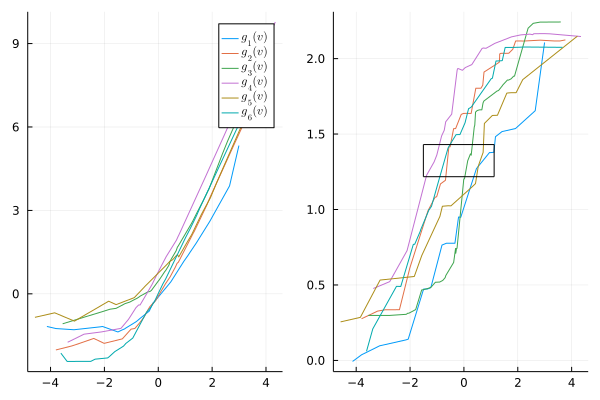

In [78]:
C0 = zeros(ncateg)
C1 = zeros(ncateg)
dgf(vv, k) = qgplsim.Gz(vv, v[z[k][2]], yz[z[k][2]], 1, τ)


p1 = plot()
p2 = plot()
for m in 1:ncateg
    C0[m] = dgf(v0, m)[1]
    C1[m] = dgf(v1, m)[1]

    vm = v[index[categ[m]]]
    dgm = dg[index[categ[m]]]
    gm = g[index[categ[m]]]
    indm = sortperm(vm)
    sorted_dgm = dgm[indm]
    sorted_gm = gm[indm]
    sorted_vm = vm[indm]
    plot!(p1, sorted_vm, sorted_gm, label = L"g_{%$m} (v)")
    plot!(p2, sorted_vm, sorted_dgm, label = false )# L"\nabla g_{%$m} (v)")

end

c0 = maximum(C0)
c1 = minimum(C1)
plot!(p2, [v0, v0], [c0, c1], color = "black", label = false)
plot!(p2, [v1, v1], [c0, c1], color = "black", label = false)
plot!(p2, [v0, v1], [c0, c0], color = "black", label = false)
plot!(p2, [v0, v1], [c1, c1], color = "black", label = false)


plot(p1, p2, layout = (1,2))

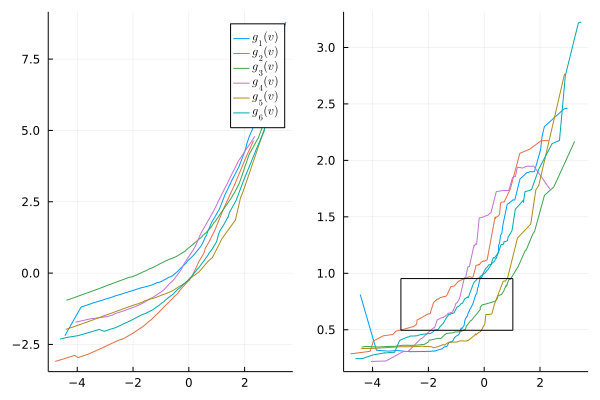

In [53]:
C0 = zeros(ncateg)
C1 = zeros(ncateg)
dgf(vv, k) = qgplsim.Gz(vv, v[z[k][2]], yz[z[k][2]], 1, τ)


p1 = plot()
p2 = plot()
for m in 1:ncateg
    C0[m] = dgf(v0, m)[1]
    C1[m] = dgf(v1, m)[1]

    vm = v[index[categ[m]]]
    dgm = dg[index[categ[m]]]
    gm = g[index[categ[m]]]
    indm = sortperm(vm)
    sorted_dgm = dgm[indm]
    sorted_gm = gm[indm]
    sorted_vm = vm[indm]
    plot!(p1, sorted_vm, sorted_gm, label = L"g_{%$m} (v)")
    plot!(p2, sorted_vm, sorted_dgm, label = false )# L"\nabla g_{%$m} (v)")

end

c0 = maximum(C0)
c1 = minimum(C1)
plot!(p2, [v0, v0], [c0, c1], color = "black", label = false)
plot!(p2, [v1, v1], [c0, c1], color = "black", label = false)
plot!(p2, [v0, v1], [c0, c0], color = "black", label = false)
plot!(p2, [v0, v1], [c1, c1], color = "black", label = false)


plot(p1, p2, layout = (1,2))

In [79]:
[C0 C1]

6×2 Matrix{Float64}:
 0.468544  1.43035
 0.464025  1.78102
 0.874062  1.93499
 1.21755   2.08242
 0.928761  1.96797
 0.781526  1.62276

# Monte Carlo Simulation

In [80]:
Threads.nthreads()

2

In [112]:
include("MonteCarloSIM.ji")

main (generic function with 4 methods)

In [145]:
α = [1.0, 0.5] # single index for x
θ = [0.5, -1.0]  # linear for x, <α, θ> = 0 for identification
γ = [0.5, 1.0] # single index for z
β = [-0.5, -0.5] # linear for z
τ = 0.5
# Q(y|x, z) = Xθ + Zβ + g(Xα + Zγ)
n = 600
fx = 2
dist = 1 # Cauchy
rep = 50 # MC rept. times

50

In [ ]:
Alpha, Gamma, Theta, Beta, Squ = MonteCarlo(n, γ, θ, α, β, τ, fx, dist, rep)

In [141]:
mb = mean(Beta, dims = 1)

1×2 Matrix{Float64}:
 -0.179049  -0.136168

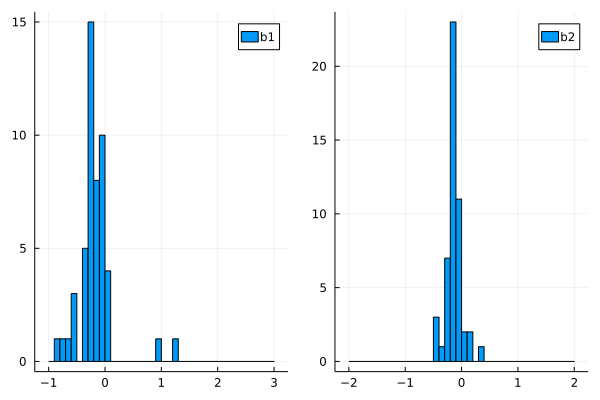

In [142]:

p1 = histogram(Beta[:,1], bins = -1:0.1:3, label = "b1")
p2 = histogram(Beta[:,2], bins = -2:0.1:2, label = "b2")
plot(p1, p2, layout = (1, 2))

In [143]:
mg = mean(Gamma, dims = 1)

1×2 Matrix{Float64}:
 0.297702  0.592293

In [144]:
Squ = Squ .* (Squ .> 0)
mean(Squ)

0.14866655823490998

In [87]:
(γ |> transpose) ./ mg

1×2 Matrix{Float64}:
 1.89388  1.52059

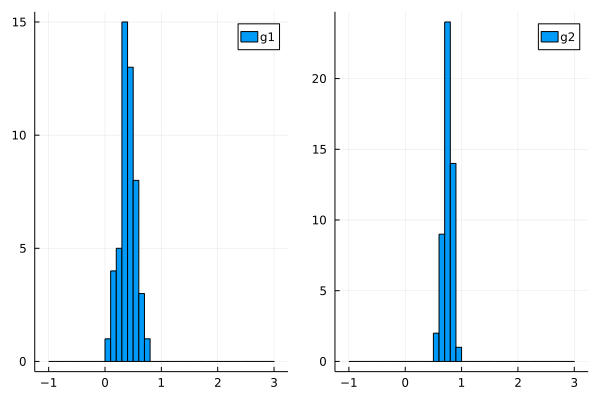

In [119]:
p1 = histogram(Gamma[:,1], bins = -1:0.1:3, label = "g1")
p2 = histogram(Gamma[:,2], bins = -1:0.1:3, label = "g2")
plot(p1, p2, layout = (1, 2))

In [89]:
ma = mean(Alpha, dims = 1)

1×2 Matrix{Float64}:
 0.84486  0.466464

In [90]:
mt = mean(Theta, dims = 1)

1×2 Matrix{Float64}:
 0.525802  -0.931531

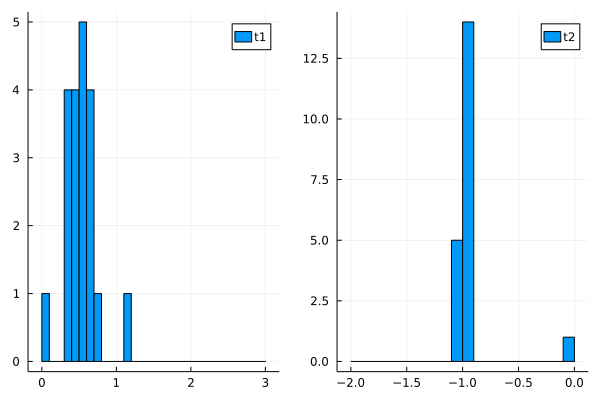

In [91]:
p1 = histogram(Theta[:,1], bins = 0:0.1:3, label = "t1")
p2 = histogram(Theta[:,2], bins = -2:0.1:-0, label = "t2")
plot(p1, p2, layout = (1, 2))

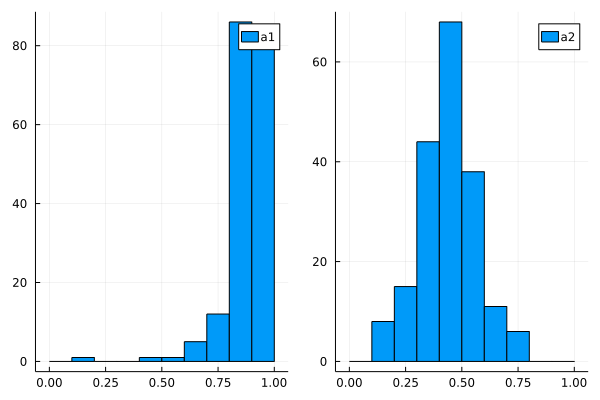

In [35]:
p1 = histogram(Alpha[:,1], bins = 0:0.1:1, label = "a1")
p2 = histogram(Alpha[:,2], bins = 0:0.1:1, label = "a2")
plot(p1, p2, layout = (1, 2))